In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
# Učitavanje Iris dataseta
iris = load_iris()
X, y = iris.data, iris.target

# Podjela na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizacija podataka
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Pretvaranje u PyTorch tenzore
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Kreiranje DataLoadera
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [33]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]
hidden_size = 16
num_classes = len(np.unique(y))

model = NeuralNet(input_size, hidden_size, num_classes)


In [34]:
# Hiperparametri
learning_rate = 0.001
num_epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Treniranje
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.7906
Epoch [20/100], Loss: 0.7451
Epoch [30/100], Loss: 0.1994
Epoch [40/100], Loss: 0.5265
Epoch [50/100], Loss: 0.4973
Epoch [60/100], Loss: 0.3405
Epoch [70/100], Loss: 0.1360
Epoch [80/100], Loss: 0.1255
Epoch [90/100], Loss: 0.1750
Epoch [100/100], Loss: 0.1612


In [35]:
# Evaluacija modela na test skupu
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Točna predikcija na test skupu: {100 * correct / total:.2f}%')


Točna predikcija na test skupu: 100.00%


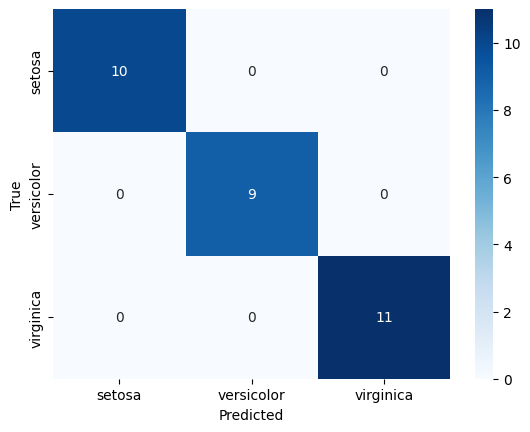

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [36]:
# Predikcija na test podacima
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

# Matrica konfuzije
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Izvještaj klasifikacije
print(classification_report(y_true, y_pred, target_names=iris.target_names))


Logistička regresija točnost: 1.00
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



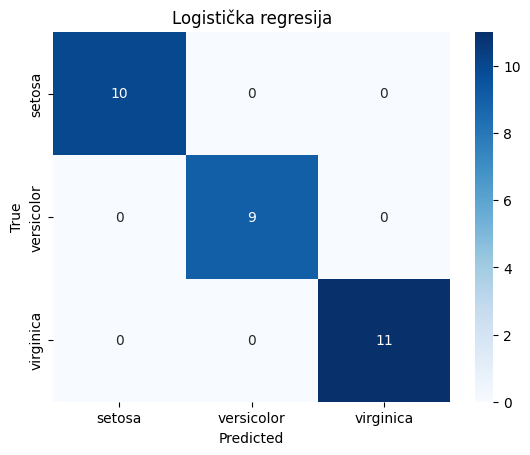

In [37]:
# Treniranje logističke regresije
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)

# Predikcija na test skupu
y_pred_log_reg = log_reg.predict(X_test)

# Evaluacija
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f'Logistička regresija točnost: {accuracy_log_reg:.2f}')
print(classification_report(y_test, y_pred_log_reg, target_names=iris.target_names))

# Matrica konfuzije
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistička regresija')
plt.show()


KNN točnost: 1.00
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



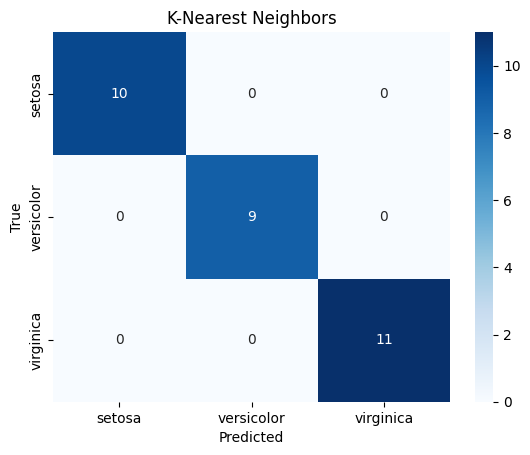

In [39]:
# Treniranje KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predikcija na test skupu
y_pred_knn = knn.predict(X_test)

# Evaluacija
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN točnost: {accuracy_knn:.2f}')
print(classification_report(y_test, y_pred_knn, target_names=iris.target_names))

# Matrica konfuzije
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Nearest Neighbors')
plt.show()


SVM točnost: 0.97
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



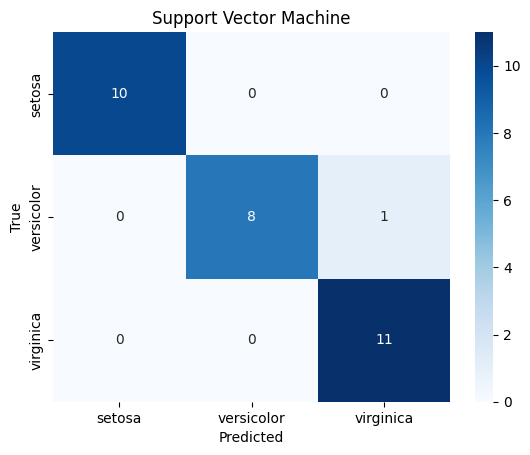

In [40]:
# Treniranje SVM
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Predikcija na test skupu
y_pred_svm = svm.predict(X_test)

# Evaluacija
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM točnost: {accuracy_svm:.2f}')
print(classification_report(y_test, y_pred_svm, target_names=iris.target_names))

# Matrica konfuzije
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Support Vector Machine')
plt.show()
